### Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import random

from montecarlo import create_sp_return_generator, create_housing_return_generator, last_entry

%matplotlib inline

### Create object that simulates the value and cost of owning a real-estate property through time

In [2]:
class REAsset:
    
    def __init__(self, initial_investment, rent_cost=1100, condo_fees=300, startup_cost=6_000, mortgate_fixed_rate=0.032,
                 property_tax_rate=0.02, school_tax_rate=0.0015, re_broker_fee=0.05, downpayment_rate=0.2, 
                 amortization_period=20, verbose=1, rent_increase_rate=0.03):
        
        self.year_counter = 0
        
        self.amortization_period = amortization_period
        self.mortgage_rate = mortgate_fixed_rate
        self.property_tax_rate = property_tax_rate
        self.school_tax_rate = school_tax_rate
        self.re_broker_fee = re_broker_fee
        self.market_value = initial_investment
        self.re_broker_fee = re_broker_fee
        self.rent_increase_rate = rent_increase_rate
        self.book_value = initial_investment
        
        if initial_investment == 0:
            self.cost = 0
            self.rent_cost = rent_cost * 12
            self.condo_fees = 0
            self.mortgage_outstanding = 0
            self.mortgage_monthly_payment = 0
            self.principal_payment = 0
            self.interest_payment = 0
        else:
            self.cost = startup_cost
            self.rent_cost = 0
            self.condo_fees = condo_fees * 12
            self.mortgage_outstanding = (1 - downpayment_rate) * initial_investment
            self.r = self.mortgage_rate / 12
            self.n = amortization_period * 12
            self.mortgage_monthly_payment = self.mortgage_outstanding * \
                                            (self.r * (1 + self.r)**self.n)/ \
                                            (((1 + self.r)**self.n)-1)
            self.principal_payment = self.mortgage_outstanding / self.n
            self.interest_payment = self.mortgage_monthly_payment - self.principal_payment
            
        self.housing_return = create_housing_return_generator()
        
        if verbose:
            print("RE Initial Investment: ${}".format(initial_investment))
            print("RE Book Value: ${}".format(self.book_value))
            print("RE Downpayment: ${}".format(downpayment_rate * initial_investment))
            print("RE Amortization Period: {} years".format(amortization_period))
            print("RE Monthly Payment Due: ${:.2f}".format(self.mortgage_monthly_payment + self.rent_cost/12))
            
    def year_end_evaluation(self):
        
        self.year_counter += 1
        
        self.market_value = self.market_value * (1 + self.housing_return())
        taxes = self.market_value * (self.property_tax_rate + self.school_tax_rate)
        
        if self.year_counter < self.amortization_period:
            self.mortgage_outstanding -= self.principal_payment * 12
            self.cost += 12 * self.interest_payment + self.condo_fees + self.rent_cost + taxes
        elif self.year_counter == self.amortization_period:
            self.mortgage_outstanding -= self.principal_payment * 12
            self.cost += 12 * self.interest_payment + self.condo_fees + self.rent_cost + taxes + self.re_broker_fee * self.market_value
        else:
            self.cost += self.condo_fees + self.rent_cost + taxes
        
        # Account for rent increase
        self.rent_cost = (1 + self.rent_increase_rate) * self.rent_cost

### Create an object that simulates your worth on S&P over time with yearly deposits

In [3]:
class StockAsset:
    
    def __init__(self, initial_investment, verbose=1, yearly_transaction_cost=100):
        
        self.yearly_transaction_cost = yearly_transaction_cost
        self.market_value = initial_investment
        self.book_value = initial_investment
        self.cost = 0
        self.sp_return = create_sp_return_generator()
        
        if verbose:
            print("Stock Initial Investment: ${}".format(initial_investment))
            
    def year_end_evaluation(self, yearly_investment):
        
        # Calculate value based on a year of accruing along with a lump-sum investment at year-end
        self.book_value = self.book_value + yearly_investment
        self.market_value = self.market_value * (1 + self.sp_return()) + yearly_investment
        self.cost += self.yearly_transaction_cost

### Simulate an investment strategy whereby you allocate funds to pay off a mortgage and the rest of your savings you put on the S&P

In [4]:
def one_sim(condo_cost, amortization_period, horizon):

    gross_salary = 68_000
    investment_rate = 0.4
    raise_rate = 0.03
    initial_investment = 20_000

    stock_asset = StockAsset(initial_investment)
    
    re_asset = REAsset(condo_cost, amortization_period=amortization_period)

    re_asset.mortgage_monthly_payment * 12

    data = []
    for year in range(horizon):

        yearly_stock_investment = investment_rate*gross_salary - re_asset.mortgage_monthly_payment * 12

        if yearly_stock_investment < 0:
            raise ValueError("You can't afford this mortgate")

        data.append({'Stock Asset: Market Value': stock_asset.market_value, 'Stock Asset: Book Value': stock_asset.book_value,
                     'Stock Asset: Accrued Cost': stock_asset.cost,
                     'RE Asset: Market Value': re_asset.market_value, 'RE Asset: Book Value': re_asset.book_value, 
                     'RE Asset: Accrued Cost': re_asset.cost})
        stock_asset.year_end_evaluation(yearly_stock_investment)
        re_asset.year_end_evaluation()

        gross_salary = (1 + raise_rate) * gross_salary
        
    total_market_value = stock_asset.market_value + re_asset.market_value
    total_cost = stock_asset.cost + re_asset.cost
    total_book_value = stock_asset.book_value + re_asset.book_value
    ROI = total_market_value / (total_book_value + total_cost)

    return pd.DataFrame(data), ROI

#### Purchase condo valued at 480,000 dollars over 20-year mortgage

Stock Initial Investment: $20000
RE Initial Investment: $480000
RE Book Value: $480000
RE Downpayment: $96000.0
RE Amortization Period: 20 years
RE Monthly Payment Due: $2168.31

ROI: 1.6745452067290014


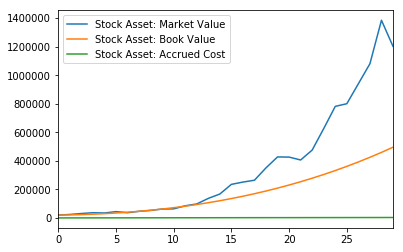

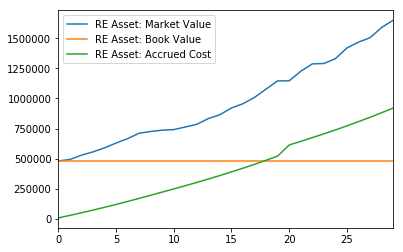

In [5]:
results, ROI = one_sim(480_000, 20, 30)
results[['Stock Asset: Market Value', 'Stock Asset: Book Value', 'Stock Asset: Accrued Cost']].plot()
results[['RE Asset: Market Value', 'RE Asset: Book Value', 'RE Asset: Accrued Cost']].plot()
print("\nROI: {}".format(ROI))

#### Rent and put all your savings on the S&P

Stock Initial Investment: $20000
RE Initial Investment: $0
RE Book Value: $0
RE Downpayment: $0.0
RE Amortization Period: 20 years
RE Monthly Payment Due: $1100.00

ROI: 0.4207770638759679


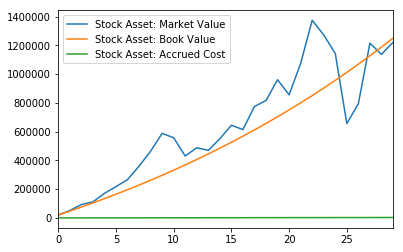

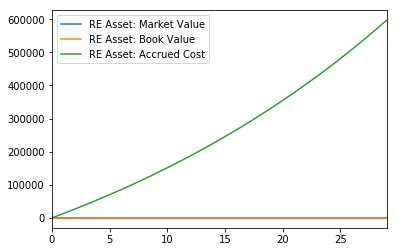

In [6]:
results, ROI = one_sim(0, 20, 30)
results[['Stock Asset: Market Value', 'Stock Asset: Book Value', 'Stock Asset: Accrued Cost']].plot()
results[['RE Asset: Market Value', 'RE Asset: Book Value', 'RE Asset: Accrued Cost']].plot()
print("\nROI: {}".format(ROI))